In [1]:
import os
from pytorch_lightning import loggers as pl_loggers
import pytorch_lightning as pl
from image_inpainting.datamodule.image_net_data_module import ImageNetDataModule
from pytorch_lightning.callbacks import ModelCheckpoint
from image_inpainting.model.context_encoder import ContextEncoder
from image_inpainting.utils import print_results_images

In [6]:
from datetime import datetime
now = datetime.now()
now = now.strftime("%Y-%m-%d_%H-%M-%S")

## Create datamodule

In [10]:
data_dir = "data"

dm = ImageNetDataModule(
    data_dir=os.path.join(data_dir, "imagenet-128"), 
    batch_size_train=512,
    batch_size_val=512,
    batch_size_test=512,
    num_workers=10, 
    pin_memory=True, 
    persistent_workers=True
)

## Create a ContextEncoder model from scratch

In [4]:
model = ContextEncoder(input_size=(3, 128, 128), hidden_size=4000, save_image_per_epoch=True, reconstruction_loss_weight = 0.99, adversarial_loss_weight = 0.01)

## Or load it from a checkpoint

In [17]:
model = ContextEncoder.load_from_checkpoint("checkpoints/imagenet_128_100_factor_losses_coefficients/2024-12-18_17-10-39-epoch=18-val_loss=0.55.ckpt") # change the path to your checkpoint
model.enable_save_image_per_epoch()
model.to("cuda")

ContextEncoder(
  (psnr_metric): PeakSignalNoiseRatio()
  (joint_loss): JointLoss(
    (rec_loss): ReconstructionLoss()
    (adv_loss): AdversarialLoss(
      (loss_function): BCELoss()
    )
  )
  (rec_loss): ReconstructionLoss()
  (adv_loss): AdversarialLoss(
    (loss_function): BCELoss()
  )
  (generator): AdversarialGenerator(
    (encoder): Encoder(
      (encoder): Sequential(
        (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
        (1): LeakyReLU(negative_slope=0.2, inplace=True)
        (2): Conv2d(64, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
        (3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (4): LeakyReLU(negative_slope=0.2, inplace=True)
        (5): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
        (6): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (7): LeakyReLU(negative_slope=0.2, inplace=True)
        (8): Conv2

## Train it

In [8]:
checkpoint_callback = ModelCheckpoint(
    dirpath='checkpoints/imagenet_128_100_factor_losses_coefficients_128_batch_512',
    filename=now+'-{epoch:02d}-{val_loss:.2f}',
    monitor='val_loss',
    save_top_k=-1,  # Save all checkpoints
    every_n_epochs=1  # Save checkpoint every n epochs
)

tb_logger = pl_loggers.TensorBoardLogger("Context_Encoder_Inpainting")
trainer = pl.Trainer(max_epochs=300, devices=-1, accelerator="cuda", logger=tb_logger, callbacks=[checkpoint_callback])

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [ ]:
trainer.fit(model, dm)

# To continue training:
# trainer.fit(model, dm, ckpt_path="checkpoints/imagenet_128_100_factor_losses_coefficients_128_batch_512/2024-12-18_12-08-15-epoch=01-val_loss=0.52.ckpt")

A notebook "tensorboard" exists if you want to check how the metrics evolve during training

## Results on the last epoch

Here the results of this cell are after 21 epochs on the full Image Net dataset cropped and resized to 128x128.

- **Number of steps**: 48 000
- **Time**: 7h30
- **Observations (with tensorboard)**: It can be really good, like in the first image with the crow. But also really bad, like on the other images

In [11]:
trainer.test(model, dm)

You are using a CUDA device ('NVIDIA GeForce RTX 3060') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


Note: The ImageNet dataset can't be downloaded automatically. Please refer to the README if you haven't already downloaded it. Otherwise you can skip this message.


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 196/196 [00:28<00:00,  6.99it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Final PSNR           13.172725677490234
        test_loss            0.535556435585022
        test_psnr           13.172529220581055
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_psnr': 13.172529220581055,
  'test_loss': 0.535556435585022,
  'Final PSNR': 13.172725677490234}]

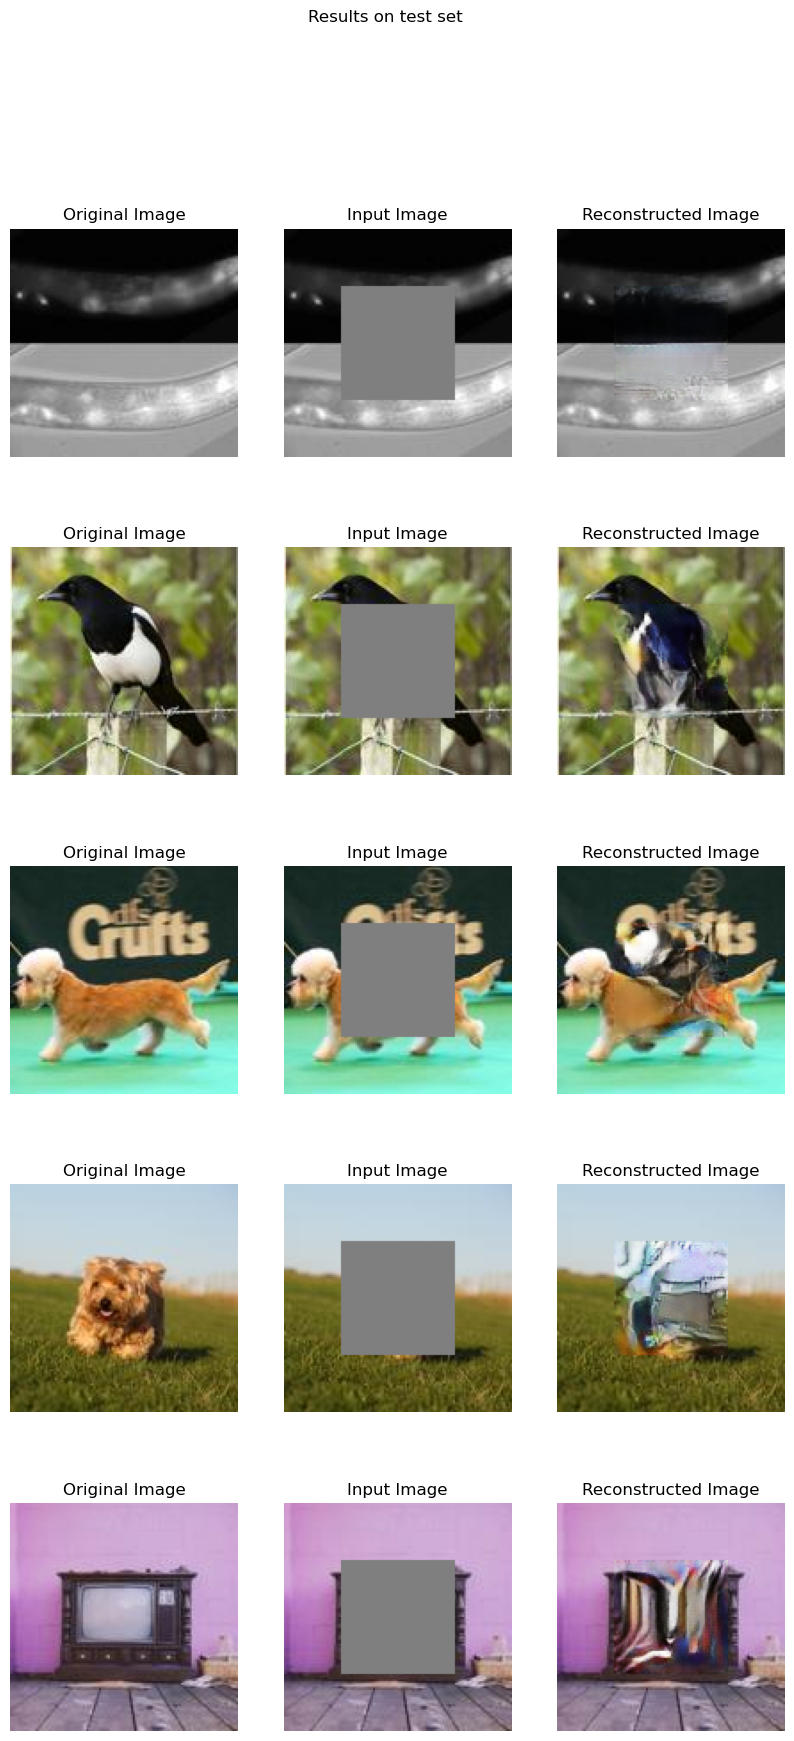

In [12]:
dm.setup("test") # in case "test" wasn't called before this cell

x, y = next(iter(dm.test_dataloader()))
x = x.to(model.device)
y = y.to(model.device)

out = model.forward(x)

print_results_images(x, y, out, "Results on test set", dm.inverse_transform)

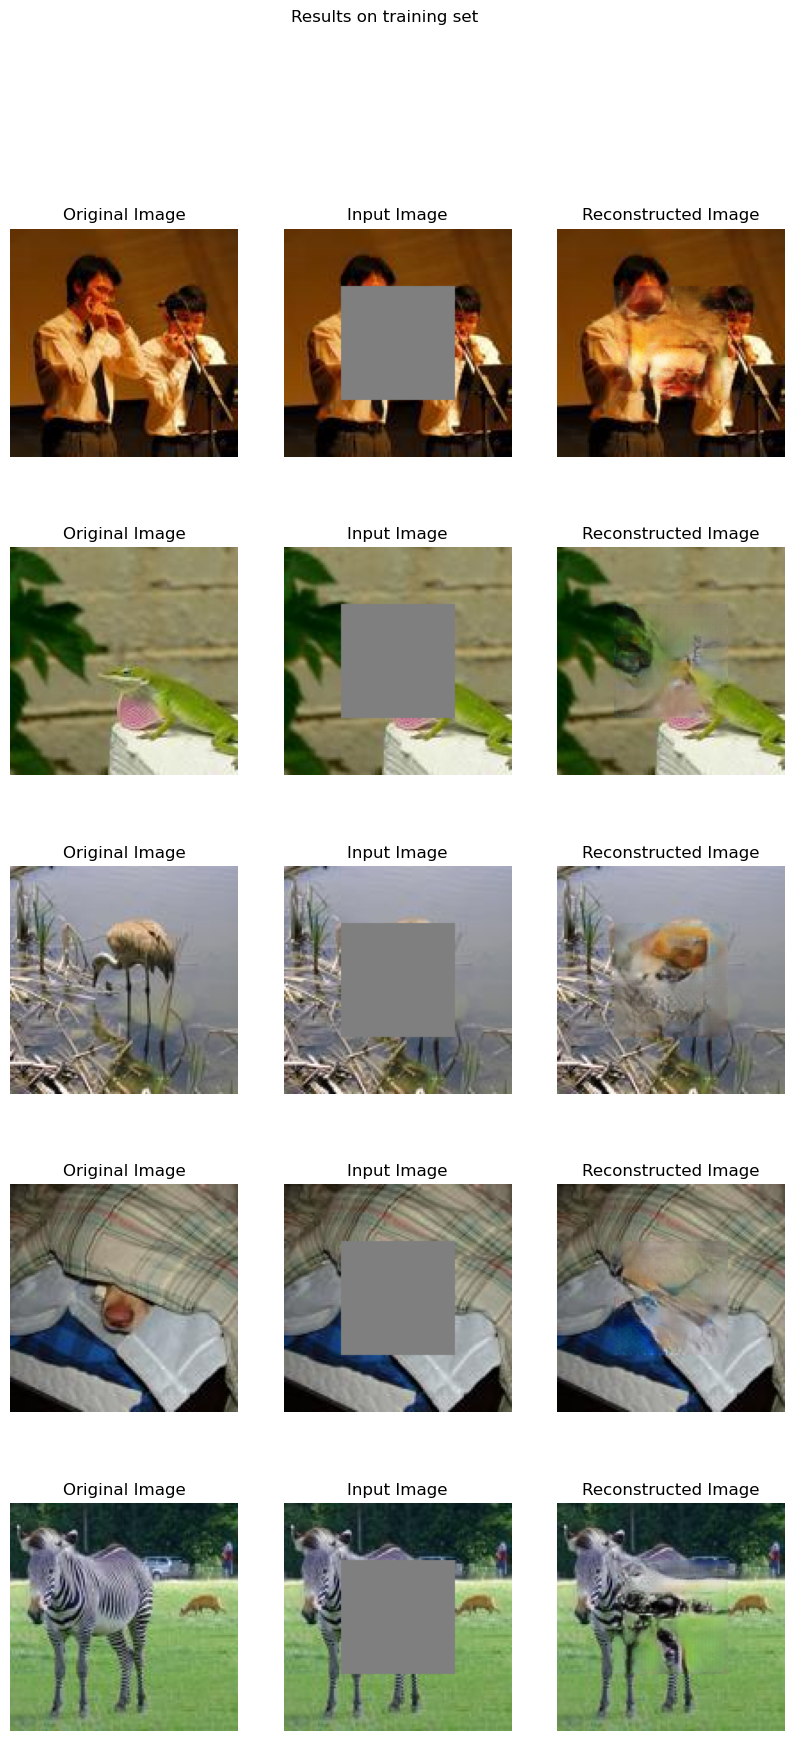

In [13]:
dm.setup("fit") # in case "fit" wasn't called before this cell

x, y = next(iter(dm.train_dataloader()))
x = x.to(model.device)
y = y.to(model.device)
out = model.forward(x)

print_results_images(x, y, out, "Results on training set", dm.inverse_transform)

## Results on the best val epoch

Here the results of this cell are after 3 epochs on the full Image Net dataset cropped and resized to 128x128.

- **Number of steps**: 7 000
- **Time**: 1h
- **Observations (with tensorboard)**: The 2 dog images are still bad

In [16]:
trainer.test(model, dm)

Note: The ImageNet dataset can't be downloaded automatically. Please refer to the README if you haven't already downloaded it. Otherwise you can skip this message.


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 196/196 [00:25<00:00,  7.57it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Final PSNR            13.54824447631836
        test_loss            0.489784836769104
        test_psnr           13.547789573669434
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_psnr': 13.547789573669434,
  'test_loss': 0.489784836769104,
  'Final PSNR': 13.54824447631836}]

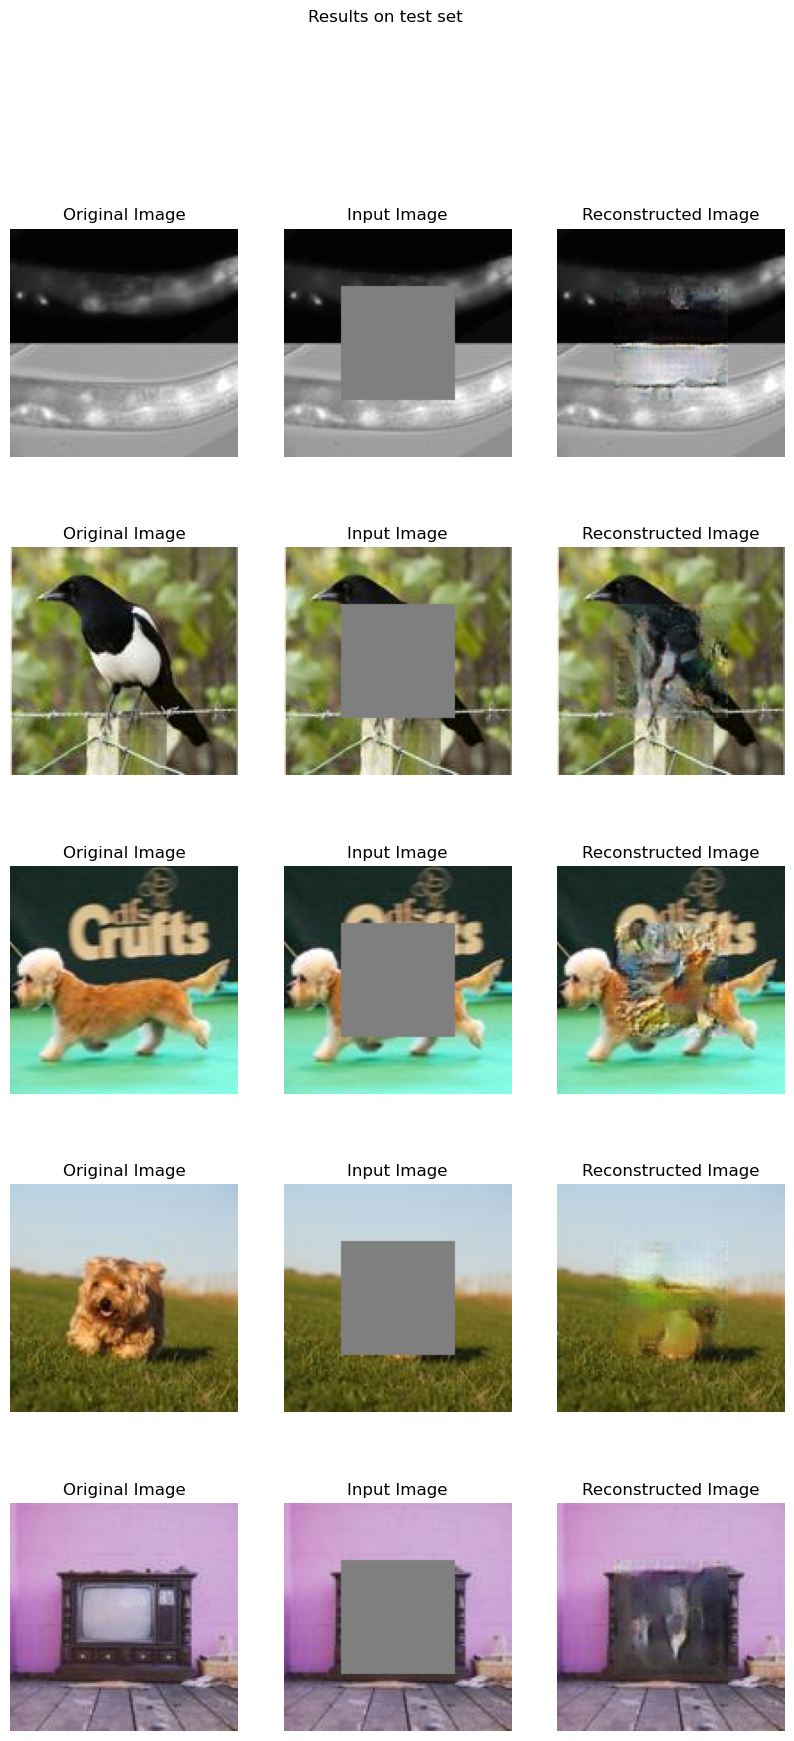

In [15]:
dm.setup("test") # in case "test" wasn't called before this cell

x, y = next(iter(dm.test_dataloader()))
x = x.to(model.device)
y = y.to(model.device)

out = model.forward(x)

print_results_images(x, y, out, "Results on test set", dm.inverse_transform)